In [1074]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1075]:
from utils import *

In [930]:
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz as gv
import numbers
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [931]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        '''
            initialize a labeled set with input dimension and ordinal attributes definition
        '''
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        '''
            vector : attribute values of example
            label : label of example
            add example to data set
        '''
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
        
    def addExamples(self, vectors, label):
        '''
            vectors : array of examples
            label : label of examples
            add examples to data set
        '''
        if (self.nb_examples == 0):
            self.x = np.array(vectors)
            self.y = np.array(label)
        else:
            self.x = np.vstack((self.x, vectors))
            self.y = np.vstack((self.y, label))
        self.nb_examples += vectors.shape[0]
    
    def getInputDimension(self):
        return self.input_dimension
    
    def size(self):
        return self.nb_examples
    
    def getX(self, i):
        return self.x[i]
        
    def getY(self, i):
        return(self.y[i])

In [932]:
class F_layer:
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError
        
    def equal_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its equal set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))
        n = labeled_set.size()

        equal_sets = np.zeros((n, n))
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            equal = values[values[:,a_j] == v][:,labeled_set.getInputDimension()]
            equal_sets[i][equal] = 1

        return equal_sets
    
    def equal_sets_label(self, labeled_set):    
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))
        n = labeled_set.size()

        equal_sets = np.zeros((n, n))

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            equal = values[values[:,0] == v][:,1]
            equal_sets[i][equal] = 1

        return equal_sets
    
    def dominant_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))
        n = labeled_set.size()

        dominant_sets = np.zeros((n, n))
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant = values[values[:,a_j] >= v][:,labeled_set.getInputDimension()]
            dominant_sets[i][dominant] = 1

        return dominant_sets

    def dominant_sets_label(self, labeled_set):
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))
        n = labeled_set.size()

        dominant_sets = np.zeros((n, n))

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant = values[values[:,0] >= v][:,1]
            dominant_sets[i][dominant] = 1

        return dominant_sets
    
class F_layer_rank(F_layer):
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, dsa, dsl, esa):
        raise NotImplementedError
        
class F_layer_non_rank(F_layer):
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError
        
class Ds(F_layer_non_rank):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return ds value of w_i, a_j
        '''
        esa_i = np.argwhere(esa[w_i] == 1).flatten()
        esl_i = np.argwhere(esl[w_i] == 1).flatten()
        intersection = np.intersect1d(esa_i, esl_i)
        
        return intersection.size * 1.0 / esa_i.size
    
class Dsr(F_layer_rank):
    
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return dsr value of w_i, a_j
        '''
        dsa_i = np.argwhere(dsa[w_i] == 1).flatten()
        dsl_i = np.argwhere(dsl[w_i] == 1).flatten()
        intersection = np.intersect1d(dsa_i, dsl_i)
        
        return intersection.size * 1.0 / dsa_i.size
    
class Minds(F_layer_non_rank):
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return minds value of w_i, a_j
        '''
        n = labeled_set.size()
        equal_set = np.argwhere(esa[w_i] == 1).flatten()
        min_l = np.iinfo(np.int32).max
        
        for w_h in equal_set:
            esa_wh = np.argwhere(esa[w_h] == 1).flatten()
            esl_wh = np.argwhere(esl[w_i] == 1).flatten()
            l = (np.intersect1d(esa_wh, esl_wh).size)
            if min_l > l:
                min_l = l
    
        return min_l * 1.0 / equal_set.size
    
class Mindsr(F_layer_rank):  
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return mindsr value of w_i, a_j
        '''
        n = labeled_set.size()
        dominant_set = np.argwhere(dsa[w_i] == 1).flatten()
        equal_set = np.argwhere(esa[w_i] == 1).flatten()
        min_l = np.iinfo(np.int32).max
        
        for w_h in equal_set:
            dsa_wh = np.argwhere(dsa[w_h] == 1).flatten()
            dsl_wh = np.argwhere(dsl[w_h] == 1).flatten()
            l = np.intersect1d(dsa_wh, dsl_wh).size
            if min_l > l:
                min_l = l
    
        return min_l * 1.0 / dominant_set.size

class Maxds(F_layer_non_rank):

    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return maxds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = np.argwhere(esa[w_i] == 1).flatten()
        max_l = np.iinfo(np.int32).min
        
        for w_h in equal_set:
            esa_wh = np.argwhere(esa[w_h] == 1).flatten()
            esl_wh = np.argwhere(esl[w_h] == 1).flatten()
            l = np.intersect1d(esa_wh, esl_wh).size
            if max_l < l:
                max_l = l    
    
        return max_l * 1.0 / equal_set.size
    
class Maxdsr(F_layer_rank):
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return maxdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        dominant_set = np.argwhere(dsa[w_i] == 1).flatten()
        equal_set = np.argwhere(esa[w_i] == 1).flatten()
        max_l = np.iinfo(np.int32).min
        
        for w_h in equal_set:
            dsa_wh = np.argwhere(dsa[w_h] == 1).flatten()
            dsl_wh = np.argwhere(dsl[w_h] == 1).flatten()
            l = np.intersect1d(dsa_wh, dsl_wh).size
            if max_l < l:
                max_l = l    
    
        return max_l * 1.0 / dominant_set.size
    
class Avgds(F_layer_non_rank):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgds value of w_i, a_j
        '''
        n = labeled_set.size()
        s = 0

        equal_set = np.argwhere(esa[w_i] == 1).flatten()

        for w_h in equal_set:
            esa_wh = np.argwhere(esa[w_h] == 1).flatten()
            esl_wh = np.argwhere(esl[w_h] == 1).flatten()
            s += np.intersect1d(esa_wh, esl_wh).size
            
        return ((1.0/equal_set.size)* s) / (1.0 * equal_set.size)
    
class Avgdsr(F_layer_rank):
    def value(self, w_i, labeled_set, dsa, dsl, esa):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            dsa : dictionnary of dominant sets generated by a_j
            dsl : dictionnary of dominant sets generated by a_j
            esa : dictionnary of equal sets generated by a_j
            return avgdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        s = 0

        dominant_set = np.argwhere(dsa[w_i] == 1).flatten()
        equal_set = np.argwhere(esa[w_i] == 1).flatten()

        for w_h in equal_set:
            dsa_wh = np.argwhere(dsa[w_h] == 1).flatten()
            dsl_wh = np.argwhere(dsl[w_h] == 1).flatten()
            s += np.intersect1d(dsa_wh, dsl_wh).size
            
        return ((1.0/equal_set.size) * s) / (dominant_set.size * 1.0)

In [1065]:
class G_layer:
    '''
        object-wise local non-monotonicity measure
    '''
        
    def value(self, f_value):
        raise NotImplementedError
        
class Log(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log_2(f_value)
        '''
        return -log(f_value, 2) 
    
class One_minus(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return 1 - f_value
        '''
        return 1 - f_value
    
class Frac(G_layer):
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log(f_value) / f_value
        '''
        return -log(f_value, 2) / (1.0 * f_value)

In [934]:
class H_layer:
    '''
        aggregated local non-monotonicity measure
    '''
        
    def value(self, g_values, labeled_set):
        raise NotImplementedError
        
class Sum(H_layer):    
    def value(self, g_values, labeled_set):
        '''
            return (1/labeled_set.size()) * sum(g_values)
        '''
        return (1.0/labeled_set.size()) * np.sum(g_values)

In [935]:
class Gdm:
    '''
        Generic rank discrimination measure
    '''
    def __init__(self, h, g, f):
        '''
            h : object-wise local monotonicity measure 
            g : object-wise local non-monotonicity measure 
            f : aggregated local non-monotonicity measure
            labeled_set : labeled set
        '''
        self.h = h 
        self.g = g
        self.f = f
    
    def value(self, labeled_set, a_j, dsa, dsl, esa, esl):
        g_f = []

        if (isinstance(self.f, F_layer_rank)):
            for i in range(0, labeled_set.size()):
                g_f.append(self.g.value(self.f.value(i, labeled_set, dsa, dsl, esa)))
        else:
            for i in range(0, labeled_set.size()):
                g_f.append(self.g.value(self.f.value(i, labeled_set, esa, esl)))
        return self.h.value(g_f, labeled_set)

In [936]:
def discretize(H, labeled_set, a_j):
    '''
        H : discrimation measure
        labeled_set : labeled set
        a_j : attribute to discretize
        return threshold which minimizes the entropy function H for given feature a_j, 
            along with minimum entropy value
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values according to attribute a_j
    
    # binary set : for each object w_i sorted in ascending order of a_j values
    # a_j(w_h) = 0 if a_j(w_h) <= a_j(w_i), 1 otherwise
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
        
    dsa = np.ones((n, n))
    dsl = H.f.dominant_sets_label(binary_set)
    esa = np.ones((n, n))
    esl = H.f.equal_sets_label(binary_set)
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        current_label = labeled_set.getY(ind[i])
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        lookahead_label = labeled_set.getY(ind[i+1])
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead or current_label == lookahead_label:
            continue
        else:
            a = np.zeros((n,))
            a[ind[:i+1]] = 1
            dsa[ind[:i+1]] = np.ones((n,))
            esa[ind[:i+1]] = a
            
            a = np.zeros((n,))
            a[ind[i+1:]] = 1
            
            dsa[ind[i+1:]] = a
            esa[ind[i+1:]] = a

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(H.value(binary_set, a_j, dsa, dsl, esa, esl))
      
    min_entropy = min(H_values)
    min_threshold = thresholds[np.argmin(H_values)]
    return (min_threshold, min_entropy)

In [937]:
def majority_class(labeled_set, labels):
    '''
        labeled_set : labeled set
        label : list of labels
        return majority class in labeled_set
    '''
    classes_size = []
    
    for label in labels:
        classes_size.append(len(labeled_set.x[np.where(labeled_set.y == label),:][0]))

    return labels[np.argmax(np.array(classes_size))]

def constant_lambda(labeled_set):
    '''
        labeled_set : labeled set
        return true if all objects in labeled_set share the same label, false otherwise
    '''
    labels = labeled_set.y
    return np.all(labels == labels[0,:], axis=0)[0]

def shannon(P):
    '''
        P : class distribution
        compute Shannon entropy
    '''
    Hs = 0
    k = len(P)
    for p_i in P:
        tmp = 0
        if p_i != 0:
            tmp = p_i * log(p_i, k)
        Hs += tmp
    
    return -Hs

def entropy(labeledSet, labels, name):
    P = []

    # get class distribution
    for label in labels:
        P.append(len(labeledSet.x[np.where(labeledSet.y == label),0:labeledSet.getInputDimension()][0]) / (1.0 * labeledSet.size()))
    
    # shannon entropy
    return shannon(P)

In [938]:
def divide(Lset, att, threshold):
    '''
        Lset : labeled_set
        att : index of attribute to divide
        threshold : threshold value
        divide Lset into two sub-sets : one with values for att <= threshold, one with values > threshold
    '''
    E1 = LabeledSet(Lset.getInputDimension())
    E2 = LabeledSet(Lset.getInputDimension())
    
    # Separate data according to threshold
    for i in range(Lset.size()):
        if Lset.getX(i)[att] <= threshold:
            E1.addExample(Lset.getX(i), Lset.getY(i))
        else:
            E2.addExample(Lset.getX(i), Lset.getY(i))
    
    return E1, E2

In [1017]:
class BinaryTree:
    '''
        Binary tree
        deal with numeric attributes (ordinal attributes have to be pre-treated and must be orderable)
        deal with multi-class classification (classes must be orderable)
    '''
    def __init__(self):
        self.attribute = None
        
        # leaf
        self.label = None
        self.labeled_set = None
        
        # internal node
        self.threshold = None
        self.inf = None
        self.sup = None
        
    def isLeaf(self):
        """ 
            return True if tree is a leaf
        """
        return self.attribute == None
    
    def add_children(self, inf, sup, att, threshold):
        """
            inf, sup : trees
            att : index of attribute
            threshold : threshold value
            add children to node
        """
        self.attribute = att
        self.threshold = threshold
        self.inf = inf
        self.sup = sup
    
    def addLeaf(self,label, labeled_set):
        """ 
            add leaf corresponding to label
        """
        self.label = label
        self.labeled_set = labeled_set
        
    def classify(self,example):
        """ 
            example : numpy array in labeled set
            classify example
        """
        if self.isLeaf():
            return self.label
        else:
            if example[self.attribute] <= self.threshold:
                return self.inf.classify(example)
            return self.sup.classify(example)
                
    def to_graph(self, g, prefix='A'):
        """ 
            build a representation of the tree
        """
        if self.isLeaf():
            g.node(prefix,str(self.label),shape='box')
        else:
            g.node(prefix, str(self.attribute))
            
            g.node(prefix, str(self.attribute))
            self.inf.to_graph(g,prefix+"l")
            self.sup.to_graph(g,prefix+"r")
            g.edge(prefix,prefix+"l", '<='+ str(self.threshold))
            g.edge(prefix,prefix+"r", '>'+ str(self.threshold))
        return g
    
    def get_depth(self):
        '''
            return tree depth
        '''
        if self.isLeaf():
            return 1
        else:
            return 1 + max(self.inf.get_depth(), self.sup.get_depth())
        
    def get_nb_leaves(self):
        '''
            return number of leaves
        '''
        if self.isLeaf():
            return 1
        else:
            return self.inf.get_nb_leaves() + self.sup.get_nb_leaves()
        
    def is_rule_monotone(self):
        '''
            return true if tree is rule monotone, false otherwise
        '''
        if (self.inf.isLeaf()) and (self.sup.isLeaf()):
            if self.inf.label > self.sup.label:
                return False
            return True
        elif self.inf.isLeaf():
            return self.sup.is_rule_monotone()
        elif self.sup.isLeaf():
            return self.inf.is_rule_monotone()
        else:
            return self.inf.is_rule_monotone() and self.sup.is_rule_monotone()
        
    def get_ratio_non_monotone_pairs(self):
        '''
            return average ratio between number of pairwise non-monotone label comparisons and number of pairs
        '''
        if (self.inf.isLeaf()) and (self.sup.isLeaf()):
            
            inf_set = self.inf.labeled_set
            sup_set = self.sup.labeled_set
            
            n_inf = inf_set.size()
            n_sup = sup_set.size()
            
            c = 0
            for i in range(n_inf):
                for j in range(n_sup):
                    if inf_set.getY(i) >= sup_set.getY(j):
                        c += 1
            return [((n_inf + n_sup) * (c * 1.0) / (n_inf * n_sup), n_inf +n_sup)]
            
            
        elif self.inf.isLeaf():
            return self.sup.get_ratio_non_monotone_pairs()
            
        elif self.sup.isLeaf():
            return self.inf.get_ratio_non_monotone_pairs()
            
        else:
            t_inf = self.inf.get_ratio_non_monotone_pairs()
            t_sup = self.sup.get_ratio_non_monotone_pairs()
            
            
            t_inf.extend(t_sup)
            return t_inf

In [940]:
def build_DT(labeled_set, H, H_stop, measureThreshold, maxDepth, percMinSize, labels, current_depth):
    '''
        labeled_set : labeled set
        H : rank discrimination measure used for discretization
        H_stop : discrimination measure (shannon, gini ...) used for stopping condition
        measure_threshold : lower bound for H_stop
        max_depth : maximum length of a path from the root to a leaf node
        percMinSize : sets the minimum size of the current object set labeled_set
        build decision tree recursively
    '''
    
    h = entropy(labeled_set, labels, "shannon")
        
    if (h <= measureThreshold) or (labeled_set.size() <= percMinSize * labeled_set.size()) or (constant_lambda(labeled_set)) or (current_depth > maxDepth):        
        leaf = BinaryTree()
        leaf.addLeaf(majority_class(labeled_set, labels), labeled_set)
        return leaf
    
    m = labeled_set.getInputDimension()
    min_threshold = None
    min_attribute = None
    
    h_values = []
    thresholds = []
    
    for a_j in range(m):
        
        # all objects share the same value for attribute a_j
        if np.all(labeled_set.x == labeled_set.x[0,:], axis = 0)[a_j]:
            thresholds.append(None)
            h_values.append(np.iinfo(np.int32).max)
            continue
        
        threshold, h = discretize(H, labeled_set, a_j)
        thresholds.append(threshold)
        h_values.append(h)
        
    min_threshold = thresholds[np.argmin(h_values)]
    min_attribute = np.argmin(h_values)
    
    
    inf_set, sup_set = divide(labeled_set, min_attribute, min_threshold)
    bt = BinaryTree()
    
    if inf_set.size() == 0:
        bt.addLeaf(majority_class(sup_set, labels), sup_set)
        return bt
    if sup_set.size() == 0:
        bt.addLeaf(majority_class(inf_set, labels), inf_set) 
        return bt
    
    inf_bt = build_DT(inf_set, H, H_stop, measureThreshold, maxDepth, percMinSize, labels, current_depth+1)
    sup_bt = build_DT(sup_set, H, H_stop, measureThreshold, maxDepth, percMinSize, labels, current_depth+1)
    bt.add_children(inf_bt, sup_bt, min_attribute, min_threshold)
    return bt

In [941]:
class Classifier:
    def __init__(self,input_dimension):
        raise NotImplementedError("Please Implement this method")
    
    def predict(self,x):
        '''
            x : example
            compute prediction on x => return score
        '''
        raise NotImplementedError("Please Implement this method")

    def train(self,labeled_set):
        '''
            labeled_set : labeled set
            train model on labeled_set
        '''
        raise NotImplementedError("Please Implement this method")
    
    def accuracy(self,labeled_set):
        '''
            labeled_set : labeled_set
            return accuracy score on whole dataset
        '''
        nb_ok=0
        for i in range(labeled_set.size()):
            score = self.predict(labeled_set.getX(i))
            if (score == labeled_set.getY(i)):
                nb_ok = nb_ok+1
        acc = nb_ok/(labeled_set.size() * 1.0)
        return acc    

In [1049]:
class RDMT(Classifier):
    '''
        Rank discrimination measure tree 
    '''
    def __init__(self, H, H_stop, measureThreshold, maxDepth, percMinSize, labels):
        '''
            H : discrimination measure to minimize for splitting
            H_stop : discrimination measure (shannon, gini ...) used for stopping condition
            measureThreshold : lower bound for the discrimination measure H
            maxDepth : maximum length of a path from the root to a leaf node
            percMinSize : minimum size of the current object set 
            labels : list of classes
        '''
        self.H = H
        self.H_stop = H_stop
        self.measureThreshold = measureThreshold
        self.maxDepth = maxDepth
        self.percMinSize = percMinSize
        self.labels = labels
        self.root = None
        
    def predict(self,x):
        '''
            classify x using RDMT
            return prediction
        '''
        label = self.root.classify(x)
        return label
    
    def train(self,labeled_set):
        '''
            set : training set
            builds RDMT using set
        '''
        self.labeled_set = labeled_set
        self.root = build_DT(labeled_set,self.H, self.H_stop, self.measureThreshold, self.maxDepth, self.percMinSize, self.labels, 0)
    
    def plot(self):
        '''
            display tree
        '''
        gtree = gv.Digraph(format='png')
        return self.root.to_graph(gtree)   
    
    def get_depth(self):
        return self.root.get_depth()
    
    def get_nb_leaves(self):
        return self.root.get_nb_leaves()
    
    def is_rule_monotone(self):
        return self.root.is_rule_monotone()
    
    def get_ratio_non_monotone_pairs(self):
        t = np.array(self.root.get_ratio_non_monotone_pairs())
        r = t[:,0].sum() / t[:, 1].sum()
        return (t[:,0].sum() / t[:, 1].sum()) / t.shape[0]
        #n = self.labeled_set.size()
        #return ((n - t[:,1].sum()) + r * (t[:,1].sum())) / n
    
    def get_total_pairs(self):
        t = np.array(self.root.get_ratio_non_monotone_pairs())
        return t.shape[0]
    
    def MAE(self, labeled_set):
        '''
            labeled_set : labeled set for evaluating the performance of the algorithm
            return mean absolute error
        '''
        s = 0
        n = labeled_set.size()
        for i in range(n):
            x = labeled_set.getX(i)
            y = labeled_set.getY(i)
            s += fabs(self.predict(x) - y)
        return (1.0/n) * s

In [943]:
def generate_2Ddataset(a_j, k, n, noise, amplitude, ranges):
    '''
        a_j : monotone attribute
        k : number of labels
        n : number of examples to create 
        noise :  % of non-monotone noise
        amplitude : amplitude of noise
        ranges : array of arrays indicating, for each attribute, its min and max values
        return 2D dataset containing k classes and n examples, with a_j being the monotone attribute
    '''
    labeled_set = LabeledSet(2)
    p = round(n/k)
    r = n # remaining examples to add 
    
    current_min = ranges[a_j][0]
    total_range = ranges[a_j][1] - ranges[a_j][0]
    
    thresholds = []
    
    for q in range(k):
        current_max = current_min + (total_range / k) 

        if (current_max > ranges[a_j][1]):
            current_max = ranges[a_j][1]
        
        if (current_max < ranges[a_j][1] and q == k-1):
            current_max = ranges[a_j][1] 
        
        
        if (p < r) and (q==k-1):
            p = r

        
        monotone_values = np.random.uniform(current_min, current_max, size=(p,1))
        
        if noise > 0:
            sample_size = np.random.binomial(len(monotone_values), noise)
            sample = np.random.randint(0, len(monotone_values), size=sample_size)
            
            for e in sample:
                if random.random() < 0.5:
                    val = current_min - random.uniform(0, total_range * amplitude)
                    if (val < ranges[a_j][0]):
                        val = ranges[a_j][0]
                    monotone_values[e] = val
                else:
                    val = current_max + random.uniform(0, total_range * amplitude)
                    if (val > ranges[a_j][1]):
                        val = ranges[a_j][1]
                    monotone_values[e] = val
        
        thresholds.append((current_min,current_max) )
        
        if (a_j == 0):
            random_values = np.random.uniform(ranges[1][0], ranges[1][1], size=(p, 1))
            values = np.hstack((monotone_values, random_values))
        else:
            random_values = np.random.uniform(ranges[0][0], ranges[0][1], size=(p,1))
            values = np.hstack((random_values, monotone_values))
        
        for i in range(p):
            labeled_set.addExample(values[i], q+1)
            
        current_min = current_max
        r -= p 
    return labeled_set, thresholds

In [944]:
def normalize(x, min_v, max_v):
    return ((x - min_v)*1.0) / (max_v - min_v) 

def generate_monotone_consistent_dataset(n, k):
    '''
        n : number of examples to create
        k : class number
        generate 2D monotone consistent dataset with n examples and k classes
            with function f(x1, x2) = 1 + x1 + (1/2) (x2^2 - x1^2)
    '''
    values = []
    x = []
    for i in range(n):
        x1 = random.uniform(0, 1)
        x2 = random.uniform(0, 1)
        x.append((x1, x2))
        v = 1 + x1 + (1/2) * (x2 * x2 - x1 * x1)
        values.append(v)
        
    max_v = max(values)
    min_v = min(values)
    results = []
    
    for i in range(n):
        results.append(normalize(values[i], min_v, max_v))
    
    x = [x for _, x in sorted(zip(results, x))]
    results = sorted(results)
    
    data = np.hstack((np.array(x), np.reshape(np.array([results]), (-1, 1))))
    
    monotone_set = LabeledSet(2)
    
    for i in range(k):
        if i == 0:
            examples = data[(data[:,2] <= 1.0/k)][:,:2]
            p = examples.shape[0]
        else:
            examples = data[(data[:,2] > (i*1.0)/k) & (data[:,2] <= (i+1.0)/k)][:,:2]
            p = examples.shape[0]
        monotone_set.addExamples(examples, np.array([[i+1]] * p))

    return monotone_set
    

In [945]:
def NMP(i, h, labeled_set):
    '''
        labeled_set : labeled set
        i, h : pair of indices in labeled_set
        return 1 if 
            (a1(w_i),...,am(w_i)) <= (a1(w_h),...,am(w_h)) and lambda(w_i) > lambda(w_h)
            or 
            (a1(w_i),...,am(w_i)) >= (a1(w_h),...,am(w_h)) and lambda(w_i) < lambda(w_h)
        0 otherwise
    '''
    w_i = labeled_set.getX(i)
    w_h = labeled_set.getX(h)
    if (np.sum(w_i - w_h)) <= 0 and (labeled_set.getY(i) > labeled_set.getY(h)):
        return 1
    if (np.sum(w_i - w_h)) >= 0 and (labeled_set.getY(i) < labeled_set.getY(h)):
        return 1
    return 0

def NMI1(labeled_set):
    '''
        labeled_set : labeled set
        return index of non-monotonicity NMI1
    '''
    n = labeled_set.size()
    
    s = 0
    for i in range(n):
        for j in range(i+1, n):
            s += NMP(i, h, labeled_set)
            
    return s / (n*n - n)

def NClash(x, y, labeled_set):
    '''
        labeled_set : labeled set
        x : example
        y : label of example
        return the number of examples that clash with x
    '''
    n = labeled_set.size()
    
    s = 0
    for i in range(n):
        z = labeled_set.getX(i)
        if (np.less_equal(z, x).all()) and (labeled_set.getY(i) > y):
            s += 1
        if (np.greater_equal(z, x).all()) and (labeled_set.getY(i) < y):
            s += 1
    return s
    

In [946]:
def generate_noisy_monotone_dataset(n, desired_NMI, lower_NMI, m, k, f):
    '''
        n : number of examples
        desired_NMI : desired non-monotonicity index
        lower_NMI : lower bound of NMI
        m : number of attributes
        k : number of ordinal class values
        f : non-decreasing monotone function
        return a dataset with the above specifications
    '''
    class_num_values = []
    x = []
    
    # step A :
    #   for each example, assign random values to the attributes
    #   compute the output as f(attribute values)
    for i in range(n):
        vector = np.random.uniform(0,1,m)
        x.append(vector)
        c = f(vector)
        class_num_values.append(c)
    
    # step B :
    #   normalize output values and sort all the examples in increasing order of normalized output values
    max_v = max(class_num_values)
    min_v = min(class_num_values)
    outputs = []
    
    for i in range(n):
        outputs.append(normalize(class_num_values[i], min_v, max_v))
    
    x = [x for _, x in sorted(zip(outputs, x))]
    outputs = np.reshape(np.array([sorted(outputs)]), (-1, 1))
    
    # step C : 
    #   assign ordinal values to the class such that the class values will be balanced
    data = np.hstack((np.array(x), np.reshape(np.array([outputs]), (-1, 1))))
    
    dataset = LabeledSet(m)
    
    for i in range(k):
        if i == 0:
            examples = data[(data[:,m] <= 1.0/k)][:,:m]
            p = examples.shape[0]
        else:
            examples = data[(data[:,m] > (i*1.0)/k) & (data[:,m] <= (i+1.0)/k)][:,:m]
            p = examples.shape[0]
        dataset.addExamples(examples, np.array([[i+1]] * p))
        
    current_NMI = NMI1(dataset)
    
    # step D
    while current_NMI < lower_NMI:
        r = random.sample(range(0, n), 2)
        x = dataset.getX(r[0])
        y = dataset.getY(r[0])
        
        if y == 1:
            # randomly select attribute values for xp that are <= relative to those of x
            xp = np.random.uniform(0, x, m)
            # class value that is > to y
            xp_y = random.randint(2, k+1)
        elif y == k+1:
            # randomly select attribute values for xp that are >= relative to those of x
            xp = np.random.uniform(x, 1, m)
            # class value that is < to y
            xp_y = random.randint(1, k)
        else:
            if random.uniform(0, 1) <= 0.5:
                xp = np.random.uniform(0, x, m)
                xp_y = random.randint(y+1, k+1)
            else:
                xp = np.random.uniform(x, 1, m)
                xp_y = random.randint(1, y-1)
        
        xs = dataset.getX(r[1])
        xs_y = dataset.getY(r[1])
        nclash_xs = NClash(xs, xs_y, dataset)
        nclash_xp = NClash(xp, xp_y, dataset)
        
        updated_NMI = nclash_xp - nclash_xs
        
        if updated_NMI < desired_NMI:
            dataset.x[r[1]] = xp
            dataset.y[r[1]] = xp_y
            current_NMI = updated_NMI
            
    return dataset

In [947]:
def plot2DSet(labeled_set, title):
    labels = list(set([item for sublist in labeled_set.y.tolist() for item in sublist]))
    mark_dict = {
        ".":"point",
        ",":"pixel",
        "o":"circle",
        "v":"triangle_down",
        "^":"triangle_up",
        "<":"triangle_left",
        ">":"triangle_right",
        "1":"tri_down",
        "2":"tri_up",
        "3":"tri_left",
        "4":"tri_right",
        "8":"octagon",
        "s":"square",
        "p":"pentagon",
        "*":"star",
        "h":"hexagon1",
        "H":"hexagon2",
        "+":"plus",
        "D":"diamond",
        "d":"thin_diamond",
        "|":"vline",
        "_":"hline"
    }    
    S = []
    for label in labels:
        S.append(labeled_set.x[np.where(labeled_set.y == label),:][0])
    for i in range(len(labels)):
        plt.scatter(S[i][:,0],S[i][:,1],marker=list(mark_dict)[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

In [948]:
def display_discretization(labeled_set, threshold, a_j, title):
    '''
        labeled_set : labeled_set
        threshold : value of threshold 
        a_j : index of discretized attribute
        title : plot title
        
        display 2D database along with threshold generated by discretization on attribute a_j
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold, threshold], [min_v, max_v])
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold, threshold])

    plt.show() 

In [949]:
def display_discretizations_comparison(labeled_set, threshold1, threshold2, real_thresholds, a_j, title, l1, l2):
    '''
        labeled_set : labeled_set
        threshold1 : threshold generated by discretization on a_j with first measure
        threshold2 : threshold generated by discretization on a_j with second measure
        real_thresholds : list of real thresholds
        title : plot title
        l1 : label of threshold1 (discrimination measure name)
        l2 : label of threshold2 (discrimination measure name)
        plot thresholds generated by two different discrimination measures on attribute a_j of labeled_set
    '''
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold1, threshold1], [min_v, max_v], color='green', label=l1)
        plt.plot([threshold2, threshold2], [min_v, max_v], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([threshold, threshold], [min_v, max_v], color='black', label="real threshold")
            else:
                plt.plot([threshold, threshold], [min_v, max_v], color='black')
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold1, threshold1], color='green', label=l1)
        plt.plot([min_v, max_v], [threshold2, threshold2], color='red', label=l2)
        for i in range(len(real_thresholds)):
            threshold = real_thresholds[i]
            if i == 0:
                plt.plot([min_v, max_v], [threshold, threshold], color='black', label="real threshold")
            else:
                plt.plot([min_v, max_v], [threshold, threshold], color='black')
    plt.legend()
    plt.show() 

In [950]:
def split_dataset(labeled_set, percentage):
    '''
        labeled_set : labeled set to split
        percentage : percentage of examples to put in the training set
        return labeled_set split into two subsets
    '''
    n = labeled_set.size()
    
    train_set = LabeledSet(labeled_set.getInputDimension())
    test_set = LabeledSet(labeled_set.getInputDimension())
    
    labels = np.unique(labeled_set.y)
    
    for k in labels:
        examples = labeled_set.x[np.where(labeled_set.y == k),:][0]
        np.random.shuffle(examples)
        p = int(examples.shape[0] * (percentage/100.0))
        train_set.addExamples(examples[:p,:], np.array([[k]] * p))
        test_set.addExamples(examples[p:,:], np.array([[k]] * (examples.shape[0] - p)))
    
    return (train_set, test_set)

In [951]:
def get_five_folds(labeled_set):
    sets = []
    labels = np.unique(labeled_set.y)
    k = labels.shape[0]
    n = labeled_set.size()
    starting_points = [0] * k
    ending_points = [-1] * k
        
    r = [0] * labels.shape[0] # remaining examples to add in each class
    
    for q in range(k):
        examples = labeled_set.x[np.where(labeled_set.y == labels[q]),:][0]
        r[q] = examples.shape[0]
    
    for i in range(5):
        dataset = LabeledSet(labeled_set.getInputDimension())
        
        for q in range(k):
            examples = labeled_set.x[np.where(labeled_set.y == labels[q]),:][0]
            p = int(round(examples.shape[0] / 5.0))
            if (i == 4) and (r[q] != p):
                ending_points[q] = examples.shape[0]
                r[q] = 0 
            else:
                ending_points[q] = starting_points[q] + p
                r[q] -= p
            
            dataset.addExamples(examples[starting_points[q]:ending_points[q],:], np.array([[labels[q]]] * (ending_points[q] - starting_points[q])))
            
            starting_points[q] = ending_points[q] 
        sets.append(dataset)
    return sets

In [952]:
def get_ten_folds(labeled_set):
    sets = []
    labels = np.unique(labeled_set.y)
    k = labels.shape[0]
    n = labeled_set.size()
    starting_points = [0] * k
    ending_points = [-1] * k
        
    r = [0] * labels.shape[0] # remaining examples to add in each class
    
    for q in range(k):
        examples = labeled_set.x[np.where(labeled_set.y == labels[q]),:][0]
        r[q] = examples.shape[0]
    
    for i in range(10):
        dataset = LabeledSet(labeled_set.getInputDimension())
        
        for q in range(k):
            examples = labeled_set.x[np.where(labeled_set.y == labels[q]),:][0]
            p = int(round(examples.shape[0] / 10.0))
            if (i == 9) and (r[q] != p):
                ending_points[q] = examples.shape[0]
                r[q] = 0 
            else:
                ending_points[q] = starting_points[q] + p
                r[q] -= p
            
            dataset.addExamples(examples[starting_points[q]:ending_points[q],:], np.array([[labels[q]]] * (ending_points[q] - starting_points[q])))
            
            starting_points[q] = ending_points[q] 
        sets.append(dataset)
    return sets

# Expérimentations sur des datasets jouets

On compare les arbres de décision crées par la rank shannon discrimination measure à ceux crées par l'entropie conditionnelle de Shannon.

In [1066]:
g = Log()
h = Sum()

f_r = Dsr()
rsdm = Gdm(h, g, f_r)

f = Ds()
sdm = Gdm(h, g, f)

f_p = Mindsr()
g_p = Frac() 
prdm = Gdm(h, g_p, f_p)

### Base créée "à la main": 

In [954]:
a_set = LabeledSet(3)
a_set.addExample([0, 0, 1], 0)
a_set.addExample([0, 1, 0], 1)
a_set.addExample([0, 1, 1], 1)
a_set.addExample([1, 0, 1], 2)

depth :  3
number of leaves :  3
rule monotone :  True


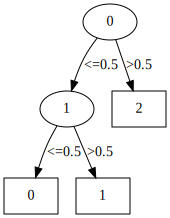

In [956]:
rdmt= RDMT(rsdm, "shannon", 0, 10, 0, [0, 1, 2])
rdmt.train(a_set)
print("depth : ", rdmt.get_depth())
print("number of leaves : ", rdmt.get_nb_leaves())
print("rule monotone : ", rdmt.is_rule_monotone())
rdmt.plot()

depth :  3
number of leaves :  3
rule monotone :  True


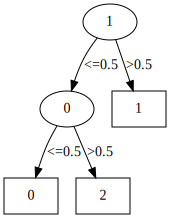

In [957]:
dmt= RDMT(sdm, "shannon", 0, 10, 0, [0, 1, 2])
dmt.train(a_set)
print("depth : ", dmt.get_depth())
print("number of leaves : ", dmt.get_nb_leaves())
print("rule monotone : ", dmt.is_rule_monotone())


dmt.plot()

## Expérimentations sur des bases à 2 dimensions dont une monotone

## Comparaison du taux de bonne classification en fonction du taux de bruit

### 2 classes :

- 10 exemples : 

-> pas de bruit :

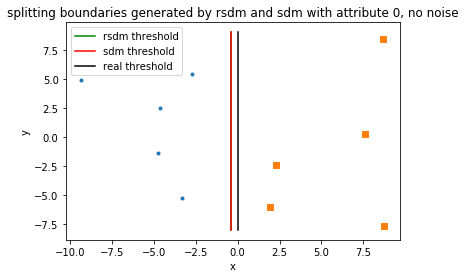

In [958]:
set2_10_0, t = generate_2Ddataset(0, 2, 10, 0., 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_0, 0)
t2, h2 = discretize(sdm, set2_10_0, 0)
display_discretizations_comparison(set2_10_0, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, no noise", "rsdm threshold", "sdm threshold")

In [959]:
train_set2_10_0, test_set2_10_0 = split_dataset(set2_10_0, 80)

depth :  2
number of leaves :  2
rule monotone :  True
accuracy :  1.0


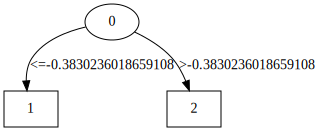

In [960]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(train_set2_10_0)
print("depth : ", rdmt2_10.get_depth())
print("number of leaves : ", rdmt2_10.get_nb_leaves())
print("rule monotone : ", rdmt2_10.is_rule_monotone())
print("accuracy : ", rdmt2_10.accuracy(test_set2_10_0))
rdmt2_10.plot()

depth :  2
number of leaves :  2
rule monotone :  True
accuracy :  1.0


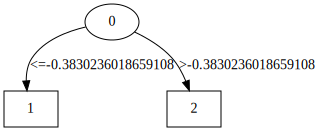

In [961]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(train_set2_10_0)
print("depth : ", dmt2_10.get_depth())
print("number of leaves : ", dmt2_10.get_nb_leaves())
print("rule monotone : ", dmt2_10.is_rule_monotone())
print("accuracy : ", dmt2_10.accuracy(test_set2_10_0))
dmt2_10.plot()

-> 30% de bruit :

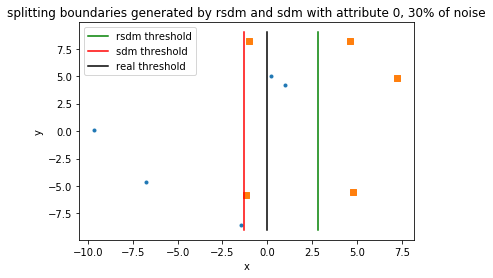

In [962]:
set2_10_30, t = generate_2Ddataset(0, 2, 10, 0.3, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_30, 0)
t2, h2 = discretize(sdm, set2_10_30, 0)
display_discretizations_comparison(set2_10_30, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 30% of noise", "rsdm threshold", "sdm threshold")

In [963]:
train_set2_10_30, test_set2_10_30 = split_dataset(set2_10_30, 80)

depth :  4
number of leaves :  4
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0


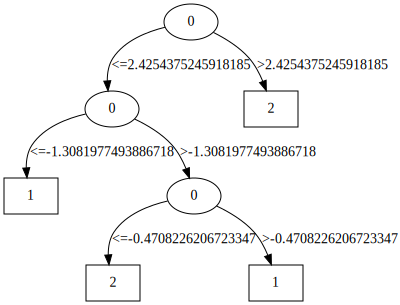

In [1024]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(train_set2_10_30)
print("depth : ", rdmt2_10.get_depth())
print("number of leaves : ", rdmt2_10.get_nb_leaves())
print("rule monotone : ", rdmt2_10.is_rule_monotone())
print("accuracy : ", rdmt2_10.accuracy(test_set2_10_30))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", rdmt2_10.get_ratio_non_monotone_pairs())

rdmt2_10.plot()

depth :  4
number of leaves :  4
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0


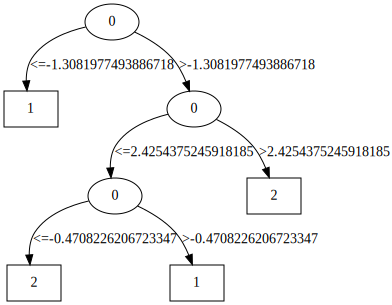

In [1025]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(train_set2_10_30)
print("depth : ", dmt2_10.get_depth())
print("number of leaves : ", dmt2_10.get_nb_leaves())
print("rule monotone : ", dmt2_10.is_rule_monotone())
print("accuracy : ", dmt2_10.accuracy(test_set2_10_30))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", dmt2_10.get_ratio_non_monotone_pairs())

dmt2_10.plot()

-> 70% de bruit :

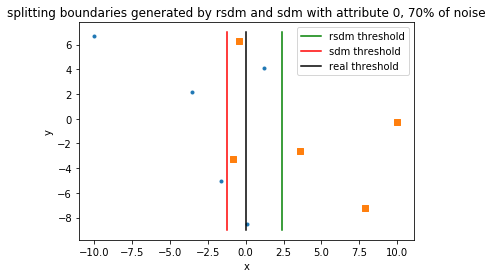

In [1026]:
set2_10_70, t = generate_2Ddataset(0, 2, 10, 0.7, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_70, 0)
t2, h2 = discretize(sdm, set2_10_70, 0)
display_discretizations_comparison(set2_10_70, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 70% of noise", "rsdm threshold", "sdm threshold")

In [1027]:
train_set2_10_70, test_set2_10_70 = split_dataset(set2_10_70, 80)

depth :  4
number of leaves :  4
rule monotone :  True
accuracy :  0.5
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.0


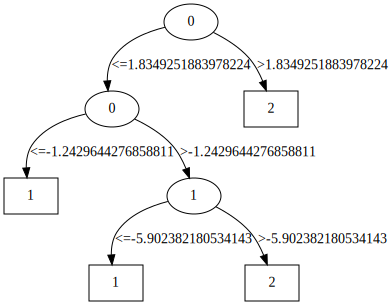

In [1028]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(train_set2_10_70)
print("depth : ", rdmt2_10.get_depth())
print("number of leaves : ", rdmt2_10.get_nb_leaves())
print("rule monotone : ", rdmt2_10.is_rule_monotone())
print("accuracy : ", rdmt2_10.accuracy(test_set2_10_70))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", rdmt2_10.get_ratio_non_monotone_pairs())

rdmt2_10.plot()

depth :  3
number of leaves :  3
rule monotone :  True
accuracy :  0.5
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.0


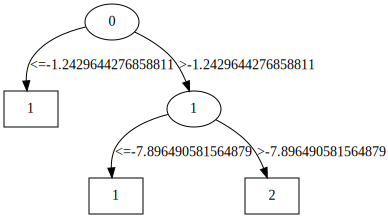

In [1029]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(train_set2_10_70)
print("depth : ", dmt2_10.get_depth())
print("number of leaves : ", dmt2_10.get_nb_leaves())
print("rule monotone : ", dmt2_10.is_rule_monotone())
print("accuracy : ", dmt2_10.accuracy(test_set2_10_70))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", dmt2_10.get_ratio_non_monotone_pairs())

dmt2_10.plot()

- 100 exemples :  

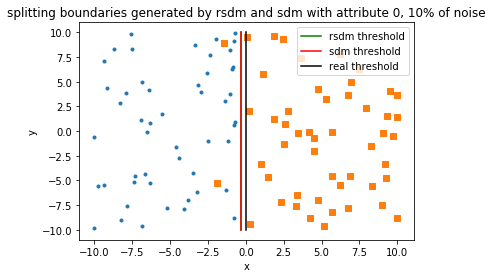

In [1050]:
set2_100, t = generate_2Ddataset(0, 2, 100, 0.1, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_100, 0)
t2, h2 = discretize(sdm, set2_100, 0)
display_discretizations_comparison(set2_100, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 10% of noise", "rsdm threshold", "sdm threshold")

In [1051]:
train_set2_100, test_set2_100 = split_dataset(set2_100, 80)

In [1052]:
sets2_100 = get_ten_folds(set2_100)

depth :  6
number of leaves :  7
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.5


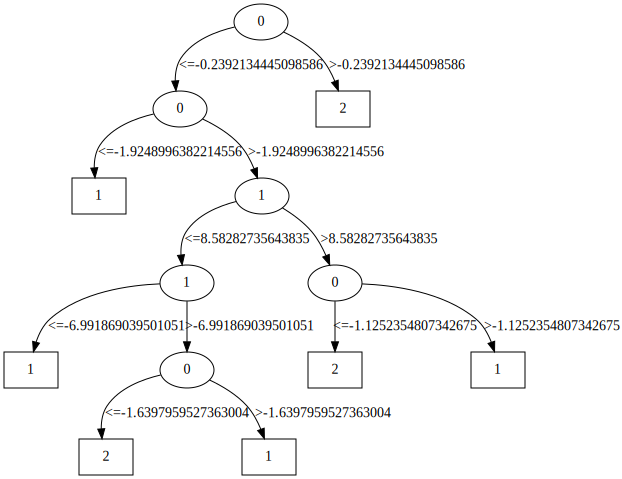

In [1053]:
rdmt2_100 = RDMT(rsdm, "shannon", 0, 100, 0.01, [1, 2])
rdmt2_100.train(train_set2_100)
print("depth : ", rdmt2_100.get_depth())
print("number of leaves : ", rdmt2_100.get_nb_leaves())
print("rule monotone : ", rdmt2_100.is_rule_monotone())
print("accuracy : ", rdmt2_100.accuracy(test_set2_100))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", rdmt2_100.get_ratio_non_monotone_pairs())
rdmt2_100.plot()


depth :  4
number of leaves :  4
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0


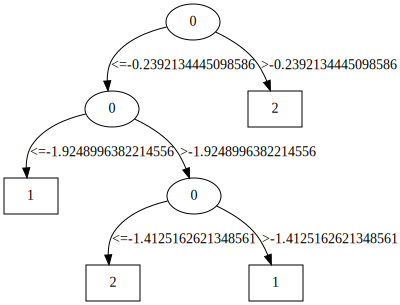

In [1054]:
dmt2_100 = RDMT(sdm, "shannon", 0, 100, 0.01, [1, 2])
dmt2_100.train(train_set2_100)
print("depth : ", dmt2_100.get_depth())
print("number of leaves : ", dmt2_100.get_nb_leaves())
print("rule monotone : ", dmt2_100.is_rule_monotone())
print("accuracy : ", dmt2_100.accuracy(test_set2_100))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", dmt2_100.get_ratio_non_monotone_pairs())

dmt2_100.plot()

In [1055]:
avg_accuracy = 0
avg_leaves = 0
avg_depth = 0
avg_ratio = 0

for i in range(10):
    test_set = sets2_100[i]
    train_set = LabeledSet(2)
    for j in range(0, 10):
        if i != j:
            train_set.addExamples(sets2_100[j].x, sets2_100[j].y)
    tree = RDMT(rsdm, "shannon", 0, 100, 0.01, [1, 2])
    tree.train(train_set)
    avg_accuracy += tree.accuracy(test_set)
    avg_leaves += tree.get_nb_leaves()
    avg_depth += tree.get_depth()
    avg_ratio += tree.get_ratio_non_monotone_pairs() 
        
avg_accuracy = avg_accuracy * (1.0/10)
avg_leaves = avg_leaves * (1.0/10)
avg_depth = avg_depth * (1.0/10)
avg_ratio = avg_ratio * (1.0/10)

print("average accuracy : ", avg_accuracy)
print("average depth : ", avg_depth)
print("average number of leaves : ", avg_leaves)
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", avg_ratio)

average accuracy :  0.9700000000000002
average depth :  5.800000000000001
average number of leaves :  6.6000000000000005
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.6000000000000001


In [1056]:
avg_accuracy = 0
avg_leaves = 0
avg_depth = 0
avg_ratio = 0

for i in range(10):
    test_set = sets2_100[i]
    train_set = LabeledSet(2)
    for j in range(0, 10):
        if i != j:
            train_set.addExamples(sets2_100[j].x, sets2_100[j].y)
    tree = RDMT(sdm, "shannon", 0, 100, 0.01, [1, 2])
    tree.train(train_set)
    avg_accuracy += tree.accuracy(test_set)
    avg_leaves += tree.get_nb_leaves()
    avg_depth += tree.get_depth()
    avg_ratio += tree.get_ratio_non_monotone_pairs() 
        
avg_accuracy = avg_accuracy * (1.0/10)
avg_leaves = avg_leaves * (1.0/10)
avg_depth = avg_depth * (1.0/10)
avg_ratio = avg_ratio * (1.0/10)

print("average accuracy : ", avg_accuracy)
print("average depth : ", avg_depth)
print("average number of leaves : ", avg_leaves)
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", avg_ratio)

average accuracy :  0.9700000000000002
average depth :  4.0
average number of leaves :  4.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0


In [1040]:
y1 = []
y2 = []

avg_leaves1 = []
avg_leaves2 = []

avg_depth1 = []
avg_depth2 = []

avg_ratio1 = []
avg_ratio2 = []

noises = np.arange(0., 1., 0.01)

start = time.time()

for noise in noises:
    dataset, t = generate_2Ddataset(0, 2, 100, noise, 0.1, [[-10, 10], [-10, 10]])
    sets = get_ten_folds(dataset)
    
    avg_accuracy = 0
    avg_leaves = 0
    avg_depth = 0
    avg_ratio = 0
    
    for i in range(10):
        test_set = sets[i]
        train_set = LabeledSet(2)
        for j in range(0, 10):
            if i != j:
                train_set.addExamples(sets[j].x, sets[j].y)
        tree = RDMT(rsdm, "shannon", 0, 100, 0.01, [1, 2])
        tree.train(train_set)
        avg_accuracy += tree.accuracy(test_set)
        avg_leaves += tree.get_nb_leaves()
        avg_depth += tree.get_depth()
        avg_ratio += tree.get_ratio_non_monotone_pairs() 
        
    avg_accuracy = avg_accuracy * (1.0/10)
    avg_leaves = avg_leaves * (1.0/10)
    avg_depth = avg_depth * (1.0/10)
    avg_ratio = avg_ratio * (1.0/10)
    
    y1.append(avg_accuracy)
    avg_leaves1.append(avg_leaves)
    avg_depth1.append(avg_depth)
    avg_ratio1.append(avg_ratio)
    
    avg_accuracy = 0
    avg_leaves = 0
    avg_depth = 0
    avg_ratio = 0
    
    for i in range(10):
        test_set = sets[i]
        train_set = LabeledSet(2)
        for j in range(0, 10):
            if i != j:
                train_set.addExamples(sets[j].x, sets[j].y)
        tree = RDMT(sdm, "shannon", 0, 100, 0.01, [1, 2])
        tree.train(train_set)
        avg_accuracy += tree.accuracy(test_set)
        avg_leaves += tree.get_nb_leaves()
        avg_depth += tree.get_depth()
        avg_ratio += tree.get_ratio_non_monotone_pairs() 
    
    avg_accuracy = avg_accuracy * (1.0/10)
    avg_leaves = avg_leaves * (1.0/10)
    avg_depth = avg_depth * (1.0/10)
    avg_ratio = avg_ratio * (1.0/10)
    
    y2.append(avg_accuracy)
    avg_leaves2.append(avg_leaves)
    avg_depth2.append(avg_depth)
    avg_ratio2.append(avg_ratio)
    
print("Running time : ", format(time.time() - start))

Running time :  1105.60710978508


In [1067]:
y1 = []
y2 = []
y3 = []

avg_leaves1 = []
avg_leaves2 = []
avg_leaves3 = []

avg_depth1 = []
avg_depth2 = []
avg_depth3 = []

avg_ratio1 = []
avg_ratio2 = []
avg_ratio3 = []

noises = np.arange(0., 1., 0.01)

start = time.time()

for noise in noises:
    dataset, t = generate_2Ddataset(0, 2, 100, noise, 0.1, [[-10, 10], [-10, 10]])
    sets = get_ten_folds(dataset)
    
    acc1 = 0
    leaves1 = 0
    depth1 = 0
    ratio1 = 0
    
    acc2 = 0
    leaves2 = 0
    depth2 = 0
    ratio2 = 0
    
    acc3 = 0
    leaves3 = 0
    depth3 = 0
    ratio3 = 0
    
    
    for i in range(10):
        test_set = sets[i]
        train_set = LabeledSet(2)
        for j in range(0, 10):
            if i != j:
                train_set.addExamples(sets[j].x, sets[j].y)
        tree1 = RDMT(rsdm, "shannon", 0, 100, 0.01, [1, 2])
        tree1.train(train_set)
        acc1 += tree1.accuracy(test_set)
        leaves1 += tree1.get_nb_leaves()
        depth1 += tree1.get_depth()
        ratio1 += tree1.get_ratio_non_monotone_pairs() 
        
        tree2 = RDMT(sdm, "shannon", 0, 100, 0.01, [1, 2])
        tree2.train(train_set)
        acc2 += tree2.accuracy(test_set)
        leaves2 += tree2.get_nb_leaves()
        depth2 += tree2.get_depth()
        ratio2 += tree2.get_ratio_non_monotone_pairs() 
        
        tree3 = RDMT(prdm, "shannon", 0, 100, 0.01, [1, 2])
        tree3.train(train_set)
        acc3 += tree3.accuracy(test_set)
        leaves3 += tree3.get_nb_leaves()
        depth3 += tree3.get_depth()
        ratio3 += tree3.get_ratio_non_monotone_pairs() 
        
    y1.append(acc1 * (1.0/10))    
    avg_leaves1.append(leaves1 * (1.0/10))
    avg_depth1.append(depth1 * (1.0/10))
    avg_ratio1.append(ratio1 * (1.0/10))
    
    y2.append(acc2 * (1.0/10))    
    avg_leaves2.append(leaves2 * (1.0/10))
    avg_depth2.append(depth2 * (1.0/10))
    avg_ratio2.append(ratio2 * (1.0/10))
    
    y3.append(acc3 * (1.0/10))    
    avg_leaves3.append(leaves3 * (1.0/10))
    avg_depth1.append(depth3 * (1.0/10))
    avg_ratio1.append(ratio3 * (1.0/10))
    
    
print("Running time : ", format(time.time() - start))

Running time :  25005.48263001442


In [1068]:
x = np.array(noises) * 100
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)

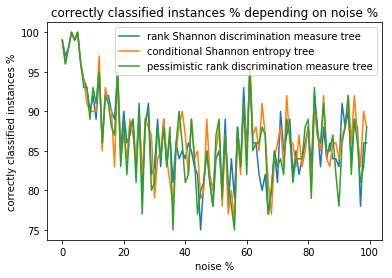

In [1069]:
plt.plot(x, y1 * 100, label="rank Shannon discrimination measure tree")
plt.plot(x, y2 * 100, label="conditional Shannon entropy tree")
plt.plot(x, y3 * 100, label="pessimistic rank discrimination measure tree")
plt.xlabel("noise %")
plt.ylabel("correctly classified instances %")
plt.title("correctly classified instances % depending on noise %")
plt.legend()
plt.show()

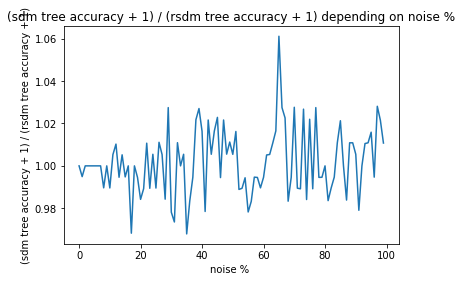

In [1070]:
z = ((y2 + 1) / (y1 + 1))
plt.plot(x, z)
plt.xlabel("noise % ")
plt.ylabel("(sdm tree accuracy + 1) / (rsdm tree accuracy + 1)")
plt.title("(sdm tree accuracy + 1) / (rsdm tree accuracy + 1) depending on noise %")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

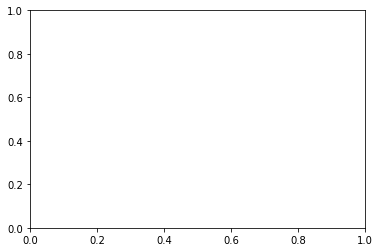

In [1071]:
plt.plot(x, avg_leaves1, label="rank shannon discrimination measure")
plt.plot(x, avg_leaves2, label="conditional Shannon entropy")
plt.plot(x, avg_leaves3, label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("average number of leaves")
plt.title("average number of leaves depending on noise %")
plt.legend()
plt.show()

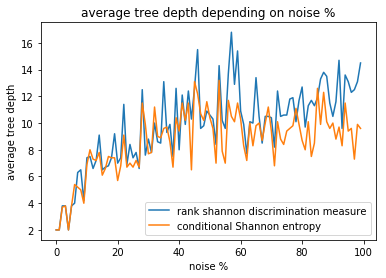

In [1046]:
plt.plot(x, avg_depth1, label="rank shannon discrimination measure")
plt.plot(x, avg_depth2, label="conditional Shannon entropy")
plt.plot(x, avg_depth3, label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("average tree depth")
plt.title("average tree depth depending on noise %")
plt.legend()
plt.show()

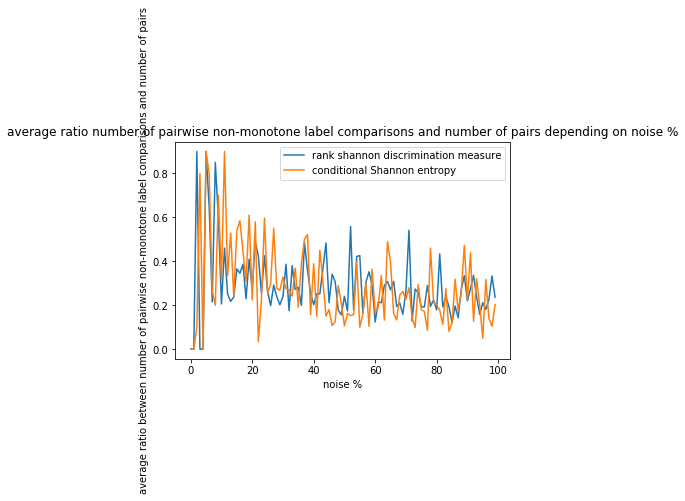

In [1047]:
plt.plot(x, avg_ratio1, label="rank shannon discrimination measure")
plt.plot(x, avg_ratio2, label="conditional Shannon entropy")
plt.plot(x, avg_ratio3, label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("average ratio between number of pairwise non-monotone label comparisons and number of pairs")
plt.title("average ratio number of pairwise non-monotone label comparisons and number of pairs depending on noise %")
plt.legend()
plt.show()

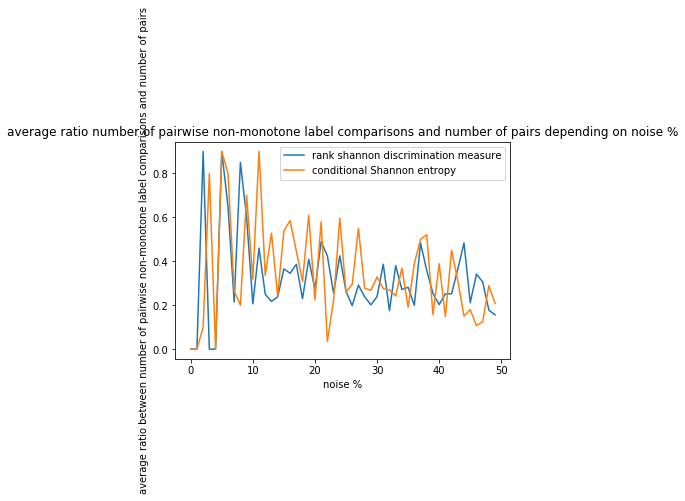

In [1061]:
plt.plot(x[0:50], avg_ratio1[0:50], label="rank shannon discrimination measure")
plt.plot(x[0:50], avg_ratio2[0:50], label="conditional Shannon entropy")
plt.plot(x[0:50], avg_ratio3[0:50], label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("average ratio between number of pairwise non-monotone label comparisons and number of pairs")
plt.title("average ratio number of pairwise non-monotone label comparisons and number of pairs depending on noise %")
plt.legend()
plt.show()

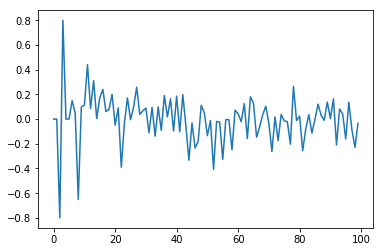

In [1063]:
plt.plot(x, np.array(avg_ratio2) - np.array(avg_ratio1))

## Expérimentations sur des datasets monotone consistent

### 2 classes :

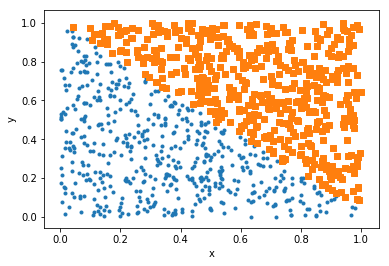

In [100]:
set2_10_0 = generate_monotone_dataset(1000, 2)

plot2DSet(set2_10_0, "")

In [ ]:
y1 = []
y2 = []

avg_leaves1 = []
avg_leaves2 = []

avg_depth1 = []
avg_depth2 = []

noises = np.arange(0., 1., 0.01)

for noise in noises:
    dataset, t = generate_2Ddataset(0, 2, 1000, noise, 0.1, [[-10, 10], [-10, 10]])
    sets = get_ten_folds(dataset)
    
    avg_accuracy = 0
    avg_leaves = 0
    avg_depth = 0
    
    for i in range(5):
        test_set = sets[i]
        train_set = LabeledSet(2)
        for j in range(0, 5):
            if i != j:
                train_set.addExamples(sets[j].x, sets[j].y)
        tree = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
        tree.train(train_set)
        avg_accuracy += tree.accuracy(test_set)
        avg_leaves += tree.get_nb_leaves()
        avg_depth += tree.get_depth()
            
    avg_accuracy = avg_accuracy * (1.0/5)
    avg_leaves = avg_leaves * (1.0/5)
    avg_depth = avg_depth * (1.0/5)
    y1.append(avg_accuracy)
    avg_leaves1.append(avg_leaves)
    avg_depth1.append(avg_depth)
    
    avg_accuracy = 0
    avg_leaves = 0
    avg_depth = 0
    
    for i in range(5):
        test_set = sets[i]
        train_set = LabeledSet(2)
        for j in range(0, 5):
            if i != j:
                train_set.addExamples(sets[j].x, sets[j].y)
        tree = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
        tree.train(train_set)
        avg_accuracy += tree.accuracy(test_set)
        avg_leaves += tree.get_nb_leaves()
        avg_depth += tree.get_depth()
    
    avg_accuracy = avg_accuracy * (1.0/5)
    avg_leaves = avg_leaves * (1.0/5)
    avg_depth = avg_depth * (1.0/5)
    y2.append(avg_accuracy)
    avg_leaves2.append(avg_leaves)
    avg_depth2.append(avg_depth)